In [1]:
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
from textblob import TextBlob
from bs4 import BeautifulSoup
import matplotlib.cm as cm
from string import punctuation
from string import digits
import pygraphviz as pgv
import networkx as nx
import pandas as pd
import itertools
import emoji
import math
import time
import json
import re

# TODO: remove this when NetworkX is fixed
from warnings import simplefilter
import matplotlib.cbook
simplefilter("ignore", matplotlib.cbook.mplDeprecation)

In [11]:
# Load edge and vertex data
edges = pd.read_csv('network-data/edges.csv')
vertices = pd.read_csv('network-data/vertices.csv')
vertices.head()

,id,screen_name,followers,friends,verified,description,created_at,listed
0,165748292,angelamrobledo,313347,13497,False,Psicóloga. Mg. en Política Social. En oposició...,2010,918
1,36352562,cataortizcamara,19912,5654,False,Caleña. Mamá de JuanFe. Abogada y maestra Admi...,2009,282
2,115074931,TMETROPOLITANO,46482,1241,False,Bienvenidos al Teatro Metropolitano; donde enc...,2010,126
3,39863994,AndreaGuerreroQ,1147763,2355,True,Periodista y conductora colombiana en RCN Tele...,2009,1886
4,167435593,Dimayor,1309051,147,True,Cuenta oficial de la División Mayor del Fútbol...,2010,1308


In [12]:
# Create graph object
G = nx.DiGraph()

for n in range(len(vertices)):
    node = vertices["id"][n]

    # Add nodes
    G.add_node(node)

    # Add attributes
    G.node[node]["ScreenName"] = vertices["screen_name"][n]
    G.node[node]["Followers"] = vertices["followers"][n]
    
for e in range(len(edges)):
    n1 = edges["source"][e]
    n2 = edges["target"][e]
    
    if n2 in G.nodes():
        G.add_edge(n1, n2, weight=1)

In [13]:
[G.number_of_nodes(), G.number_of_edges()]

[47, 83]

In [5]:
# Import tweets
tweets = pd.read_csv('tweets/statuses.csv')

tweets.head(n=5)

,id,tweet_id,created_at,text,favorite_count,retweet_count,phone,sensitive,hashtags,no_hashtags,mentions,no_mentions,no_urls,no_media
0,147993143,1167879152017428481,2019-08-31 19:17:42,¿Ustedes también perciben que usar bolsas de r...,91,26,Twitter for iPhone,False,-,0,[],0,1,0
1,147993143,1167842013443764225,2019-08-31 16:50:08,Mujeres que admiro 👇🏽 https://t.co/3V6sPgDPpk,26,1,Twitter for iPhone,False,-,0,[],0,1,0
2,147993143,1166978731208056832,2019-08-29 07:39:45,#FreeIranianFeminists https://t.co/ApJKs2Kh7M,17,5,Twitter Web App,False,FreeIranianFeminists,1,[],0,1,0
3,147993143,1166976796790796288,2019-08-29 07:32:04,#NoAlFracking #NoPermitanElFracking https://t....,2,2,Twitter Web App,False,NoAlFracking;NoPermitanElFracking,2,[],0,1,0
4,147993143,1166963208529305600,2019-08-29 06:38:04,3.5 millones de razones para seguir luchando p...,4,2,Twitter Web App,False,-,0,[],0,1,0


In [6]:
# Add weighs to graph based on mentions
for index, row in tweets.iterrows():
    author_id = row['id']
    mentions = row['mentions'][1:len(row['mentions'])-1].split(', ')
    for m in mentions:
        if m:
            mentioned_id = int(m)
            if G.has_edge(author_id, mentioned_id):
                # Increase weight by 1 for every mention
                G[author_id][mentioned_id]['weight'] = G[author_id][mentioned_id]['weight']+1

In [13]:
# Import spanish stop word dictionary
with open('utils/stopwords-es.json', 'r') as f:
    stop_words = json.load(f)
stop_words = set(stop_words)

# Import emoji meanings
emoji_translations = pd.read_csv('utils/emojis_translated.csv')

# Get spanish meaning of an emoji
def emoji_meaning(emoji):
    meaning = emoji_translations.loc[emoji_translations['emoji'] == emoji]['translation']
    return meaning.values[0] if not meaning.empty else ''

# Transformations to remove digits and punctuation
remove_digits = str.maketrans('', '', digits)
remove_punctuation = str.maketrans('', '', punctuation)

In [24]:
""" Processes text data in tweets
    
    text: text of tweet
    word_counts: word count dictionary
    
    returns processed text, length of content, polarity, subjectivity
    """
def process_text(text, word_counts):
    # Remove links
    text = ' '.join(re.sub("(\w+:\/\/\S+)", " ", text).split())
        
    # Remove mentions
    text = ' '.join(re.sub("(@[A-Za-z0-9^\w]+)", " ", text.replace('@ ','@').replace('# ','#')).split())
        
    # Replace hashtags with words
    if text.count('#')>0:
        text = ' '.join(re.findall('[A-Z][^A-Z]*', text.replace('#', ' ')))
            
    #Remove HTML tags
    text = BeautifulSoup(text).get_text()
    
    # Save content length (exluding links and mentions)
    length = len(text)
        
    # Remove punctuation symbols
    text = ' '.join(re.sub("[\.\,\¡\¿\!\?\:\;\-\=\*\(\)\[\]\"\'\“\_\+\”\%\/\‘]", " ", text).split())
    text = text.translate(remove_digits).translate(remove_punctuation)
        
    # Lower case to avoid case sensitive problems
    text = text.lower()
        
    # Replace emojis with names 
    text = emoji.demojize(text)
        
    # Add space between emojis and other characters
    ind = -2
    for c in range(text.count(':')):
        ind = text.find(':',ind+2)
        if c%2==0:
            newLetter = ' :'
        else:
            newLetter = ': '
        text ="".join((text[:ind],newLetter,text[ind+1:]))
            
    # Replace emoji names with spanish meaning
    result = []
    parts = text.split(' ')
    for part in parts:
        if part:
            if part[0]==':':
                em = handle_emoji_tone(part)
                em = emoji_meaning(em)
                if em:
                    result.append(em)
            else:
                if part not in stop_words:
                    if part not in word_counts:
                        word_counts[part] = 1
                    else:
                        word_counts[part] += 1
                result.append(part)
        
    text = ' '.join(result)
        
    # Filter using NLTK library append it to a string
    word_tokens = word_tokenize(text)
        
    result = [w for w in word_tokens if not w in stop_words]
        
    text = ' '.join(result)
        
    analysis = TextBlob(text)
    try:
        eng = analysis.translate(to='en')
    except:
        print('a')
        eng = analysis
    sentiment = eng.sentiment     
    polarity = sentiment.polarity
    subjectivity = sentiment.subjectivity
    time.sleep(.3)

    return text, length, polarity, subjectivity

tones = ['_light_skin_tone','_medium-light_skin_tone','_medium_skin_tone', 
             '_medium-dark_skin_tone','_dark_skin_tone']

# Method that removes the tone from emojis
def handle_emoji_tone(emoji):  
    for t in tones:
        if t in emoji:
            tone = t
            return emoji.replace(tone,'')
    return emoji
wc = {}
process_text('alegría colombia egan campeón corazon amarillo corazón azul corazón rojo tour francia egan campeon tour egan ', wc)




a


('alegría colombia egan campeón corazon amarillo corazón azul corazón rojo tour francia egan campeon tour egan',
 108,
 0.0,
 0.0)

In [19]:
''' Text analysis '''

# List for sentiment analysis results

# Get k most frequent words for each user
#for n in G.nodes():
for i in range(1):
    
    # Frequent word dictionary
    freq_words = {}

    # Frequent hashtag dictionary
    freq_hashtags = {}

    # Frequent words in hashtags dictionary
    freq_ht_words = {}
    
    user_tweets = tweets.loc[tweets['id'] == 386050296]
    for index, row in user_tweets.iterrows():
        
        # Get hashtags
        ht = row['hashtags'].split(';') if row['hashtags'] != '-' else []
        
        # Update hashtag count
        for hashtag in ht:
            if hashtag not in freq_ht_words:
                freq_hashtags[hashtag] = 1
            else:
                freq_hashtags[hashtag] += 1
        
        # Separate hashtags by capitalization
        ht_words = [re.findall('[a-zA-Z][^A-Z]*', w) for w in ht]
        
        # Create a list with all the words in the hashtags
        hts = []
        for h in ht_words:
            hts = hts + h
        
        # Remove digits and lower caps for every hashtag word
        hts = [item.translate(remove_digits).lower() for item in hts]
        
        # Update hashtag word frequencies
        for word in hts:
            if word not in stop_words:
                if word not in freq_ht_words:
                    freq_ht_words[word] = 1
                else:
                    freq_ht_words[word] += 1
        
        text, length, polarity, subjectivity = process_text(row['text'], freq_words)
        
        # Update text in  data frame
        print('Original:',row['text'],'\nProcessed:',text,'\nPolarity, subjectivity, length:',
              polarity, subjectivity, length, '\n')
    
    c_words = Counter(freq_words)
    c_ht_words = Counter(freq_ht_words)
    c_hashtags = Counter(freq_hashtags)
    print (c_words.most_common(5))
    print (c_ht_words.most_common(5))
    print (c_hashtags.most_common(5))

Original: ¡Qué alegría, Colombia! ¡Egan Campeón! 💛💙❤️ #TourDeFrancia2019 #EganCampeon #ElTourDeEgan https://t.co/YWY22YWJo0 
Processed: alegría colombia egan campeón corazon amarillo corazón azul corazón rojo tour francia egan campeon tour egan 
Polarity, subjectivity, length: 0.0 0.0 100 

Original: 👏👏👏💛💙❤️¡El corazón se quiere salir! Egan Bernal, campeón virtual del Tour de Francia https://t.co/3WknF84sQh https://t.co/TABDnJXrCB 
Processed: aplaudir aplaudir aplaudir corazon amarillo corazón azul corazón rojo corazón salir egan bernal campeón virtual tour francia 
Polarity, subjectivity, length: 0.0 0.0 84 

Original: 💛💛💛¡El sueño amarillo está cerca! Egan Bernal, nuevo líder del Tour de Francia https://t.co/Z9pwowhKmr https://t.co/hKkyzZzQkK 
Processed: corazon amarillo corazon amarillo corazon amarillo sueño amarillo egan bernal líder tour francia 
Polarity, subjectivity, length: 0.0 0.0 78 

Original: ¡Tremendo y fantástico! El pedalista boyacense Nairo Quintana realizó una gran e

Original: Una caminata por el centro histórico de Tunja, desde la "Esquina de la Pulmonía", con el futuro Alcalde @suarezvacca @PoloDemocratico @gustavotrianasu https://t.co/BY7gFD9WC7 
Processed: caminata centro histórico tunja esquina pulmonía futuro alcalde 
Polarity, subjectivity, length: 0.0 0.0 103 

Original: Nosotros queremos que la gente nos escuche, no que nos obedezca; porque el @PoloDemocratico se ha caracterizado por las controversias -que nos enriquecen-. Jamás buscaremos el apoyo popular con tamales o almuerzos, sino con propuestas.  @suarezvacca  @gustavotrianasu @poloboyaca https://t.co/Dw3VUnq6fe 
Processed: gente escuche obedezca caracterizado controversias enriquecen jamás buscaremos apoyo popular tamales almuerzos propuestas 
Polarity, subjectivity, length: 0.6 0.9 218 

Original: Reunidos con el presidente departamental del @PoloDemocratico, padre Gustavo Suárez; el presidente del @PoloTunja, Arturo Navas; nuestro candidato a la Alcaldía @suarezvacca y varios cand

In [36]:
# Join tweet df and sentiment analysis df



(8.370509999999996, 486.97149, -19.2183, 409.6783)

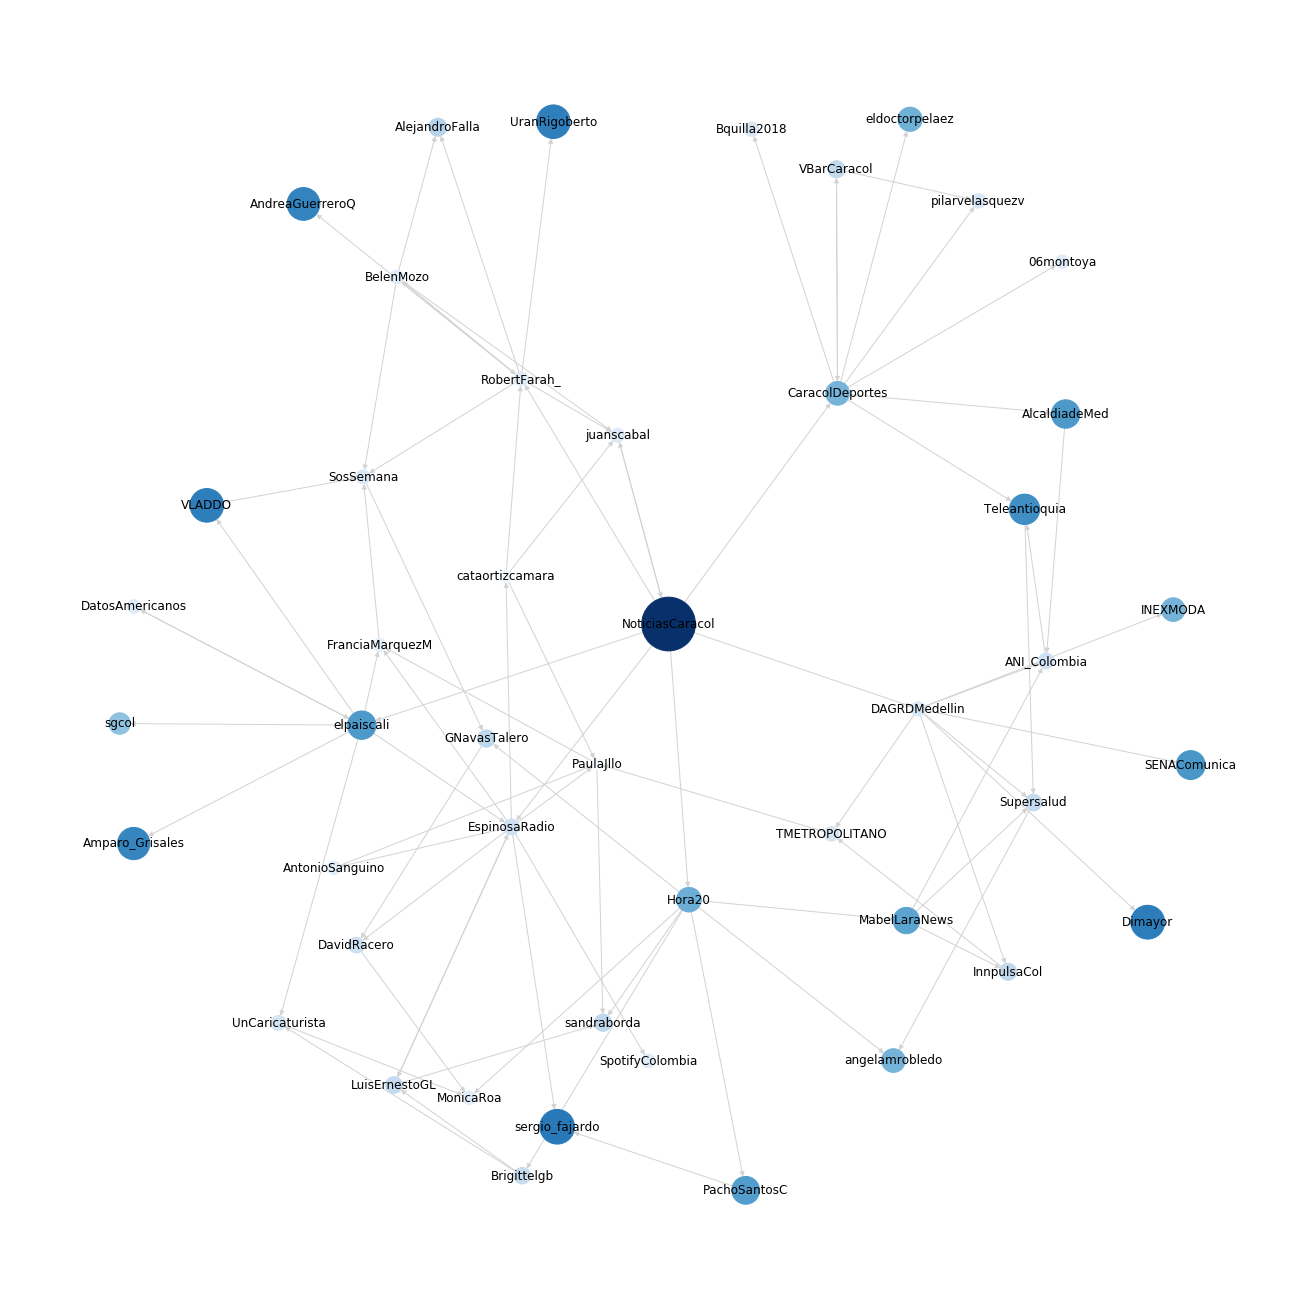

In [28]:
# Draw network

fig = plt.figure(figsize=(18,18))
        
nx.draw(G, 
        node_color=[math.log(y["Followers"]) for x,y in G.nodes(data=True)],cmap=cm.get_cmap("Blues"),
        labels = {v: G.node[v]["ScreenName"] for v in G.nodes() if "ScreenName" in G.node[v]},
                  node_size=[math.sqrt(G.node[v]["Followers"]) for v in G],
                  edge_color="lightgray",with_labels=True, pos = nx.nx_agraph.graphviz_layout(G), prog='neato')
plt.axis("tight")
# plt.savefig('graph.png')


In [26]:
''' Network measures '''

# Centrality
deg_centrality = nx.degree_centrality(G)
eig_centrality = nx.eigenvector_centrality(G)
katz_centrality = nx.katz_centrality(G)
close_centrality = nx.closeness_centrality(G)
between_centrality = nx.betweenness_centrality(G)
harmonic_centrality = nx.harmonic_centrality(G)

# Create user dataset
user_data = []
for n,d in G.nodes(data=True):
    user_data.append([n, deg_centrality[n], eig_centrality[n], katz_centrality[n],
                close_centrality[n], between_centrality[n], harmonic_centrality[n]])

user = pd.DataFrame(user_data)
user.columns=['id', 'degree', 'eigenvector', 'katz','closeness', 'betweenness',
           'harmonic']



In [27]:
# Merge vertices dataframe and 'user' dataframe
df_merge = pd.merge(user, vertices, on='id')
df_merge.head()

,id,degree,eigenvector,katz,closeness,betweenness,harmonic,screen_name,followers,friends,verified,description,created_at,listed
0,165748292,0.043478,0.108885,0.148961,0.112112,0.000000,7.069048,angelamrobledo,313347,13497,False,Psicóloga. Mg. en Política Social. En oposició...,2010,918
1,36352562,0.086957,0.112160,0.135804,0.077640,0.086473,4.250000,cataortizcamara,19912,5654,False,Caleña. Mamá de JuanFe. Abogada y maestra Admi...,2009,282
2,115074931,0.065217,0.078125,0.147460,0.077470,0.010386,5.235714,TMETROPOLITANO,46482,1241,False,Bienvenidos al Teatro Metropolitano; donde enc...,2010,126
3,39863994,0.021739,0.102766,0.135560,0.071093,0.000000,4.233333,AndreaGuerreroQ,1147763,2355,True,Periodista y conductora colombiana en RCN Tele...,2009,1886
4,167435593,0.021739,0.043348,0.132847,0.054920,0.000000,3.527381,Dimayor,1309051,147,True,Cuenta oficial de la División Mayor del Fútbol...,2010,1308


In [40]:
emoji.demojize('💔👇🏽👏🏽✊🏽💚 https://t.co/sFqq71JU5a ')

':broken_heart::backhand_index_pointing_down_medium_skin_tone::clapping_hands_medium_skin_tone::raised_fist_medium_skin_tone::green_heart: https://t.co/sFqq71JU5a '